# `meanderpy` River Example

This notebook focuses on using the `meanderpy` package to generate synthetic river networks that will be used to test `WigglyRivers` functionallity on detecting meanders and calculating metrics. 

`meanderpy` is a Python package that produces meandering rivers using a simple kinematic model presented in Howard & Knutson (1984) (Sylvester, Z., 2023). The package GitHub repository can be found [here](https://github.com/zsylvester/meanderpy) and can be installed using the following command:

```bash
pip install meanderpy
```

To start this example we first import the packages necessary to run the code.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl

In [2]:
# Importing Packages
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from IPython.display import Image, display, HTML
from IPython.display import display
from scipy.spatial import Delaunay
from scipy.spatial.distance import euclidean
from scipy import interpolate
import statsmodels.api as sm

import meanderpy as mp

# Importing WigglyRivers Packages
from WigglyRivers import RiverDatasets, RiverTransect
from WigglyRivers import RiverFunctions as RF
from WigglyRivers import ExtractNHDPlusHRData as NHD
from WigglyRivers.utilities import utilities as utl
from WigglyRivers.utilities import filesManagement as FM
from WigglyRivers.utilities import graphs
from WigglyRivers import Logger
from WigglyRivers import WaveletTreeFunctions as WTFunc
from WigglyRivers import iwavelet

# Set seed for numpy
np.random.seed(0)

In [3]:
# Start Logger
logger = Logger(console=True)

2024-02-01 13:16:04,084[INFO] set_logger: Starting log


## Synthetic River Networks Analysis

### Generate Synthetic Rivers

We use the example in the `meanderpy` repository to generate a series of synthetic rivers that will be used in our analysis. The code below will generate and save four meandering rivers with multiple complexities. From the simple sinuos-like river to the more complex river with multiple bends and loops.

**Keep in mind that the model will take some time to run.**

In [4]:
# ------------------------------
# Create River with meanderpy
# ------------------------------
nit = 1500                   # number of iterations
W = 200                      # channel width (m)
D = 6.0                     # channel depth (m)
depths = D * np.ones((nit,))  # channel depths for different iterations
pad = 100                    # padding (number of nodepoints along centerline)
deltas = 50.0                # sampling distance along centerline
Cfs = 0.011 * np.ones((nit,)) # dimensionless Chezy friction factor
crdist = 2 * W               # threshold distance at which cutoffs occur
kl = 60.0/(365*24*60*60.0)   # migration rate constant (m/s)
kv =  1.0e-12               # vertical slope-dependent erosion rate constant (m/s)
dt = 2*0.05*365*24*60*60.0     # time step (s)
dens = 1000                  # density of water (kg/m3)
saved_ts = 20                # which time steps will be saved
n_bends = 100                 # approximate number of bends you want to model
Sl = 0.0                     # initial slope (matters more for submarine channels than rivers)
t1 = 500                    # time step when incision starts
t2 = 700                    # time step when lateral migration starts
t3 = 1200                    # time step when aggradation starts
aggr_factor = 2e-9         # aggradation factor (m/s, about 0.18 m/year, it kicks in after t3)

ch = mp.generate_initial_channel(W, depths[0], Sl, deltas, pad, n_bends) # initialize channel
chb = mp.ChannelBelt(channels=[ch], cutoffs=[], cl_times=[0.0], cutoff_times=[]) # create channel belt object

chb.migrate(nit,saved_ts,deltas,pad,crdist,depths,Cfs,kl,kv,dt,dens,t1,t2,t3,aggr_factor) # channel migration
# migrate an additional 1000 iterations and plot results
chb.migrate(1000,saved_ts,deltas,pad,crdist,depths,Cfs,kl,kv,dt,dens,t1,t2,t3,aggr_factor)

# ------------------------------
# Save Dataset
# ------------------------------
n_channels = len(chb.channels)
channels_to_save = [50, 80, 123]
data = {}
for i, i_ch in enumerate(channels_to_save):
    x_ch = chb.channels[i_ch].x
    y_ch = chb.channels[i_ch].y
    data[str(i)] = {'x': x_ch, 'y': y_ch}

FM.save_data(data, path_output='synthetic_rivers/',
             file_name='synthetic_rivers_meanderpy.hdf5')
print('Synthetic Rivers Generated and Saved Succesfully')

100%|██████████| 1000/1000 [18:38<00:00,  1.12s/it]

Synthetic Rivers Generated and Saved Succesfully


Let's look at the meandering channels generated by `meanderpy`:

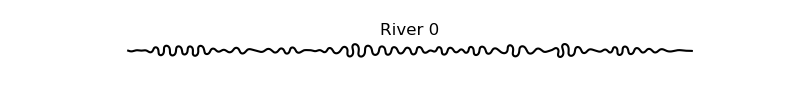

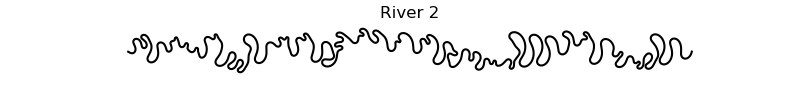

In [5]:
data = FM.load_data('synthetic_rivers/synthetic_rivers_meanderpy.hdf5')
river_ids = list(data.keys())
plt.close('all')
for river_id in river_ids:
    x_ch = data[river_id]['x'][155:-155]
    y_ch = data[river_id]['y'][155:-155]
    plt.figure(figsize=(8, 1))
    plt.plot(x_ch, y_ch, '-k')
    # plt.plot(x_ch, y_ch, 'ob')
    plt.title(f'River {river_id}')
    plt.gca().set_aspect('equal', adjustable='box')
    # Remove ticks
    plt.xticks([])
    plt.yticks([])
    # Remove axis lines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    utl.cr_folder('synthetic_rivers/results')
    plt.savefig(f'synthetic_rivers/results/river_{river_id}.png', dpi=300)
    plt.show()


### Adding Noise to the River

To reflect real data samples, we added noise into the synthetic rivers and included that information into the data for comparison. We also perform the numerical computation of the curvature of the original coordiates to have a comparison to the ones calculated by `WigglyRivers`.


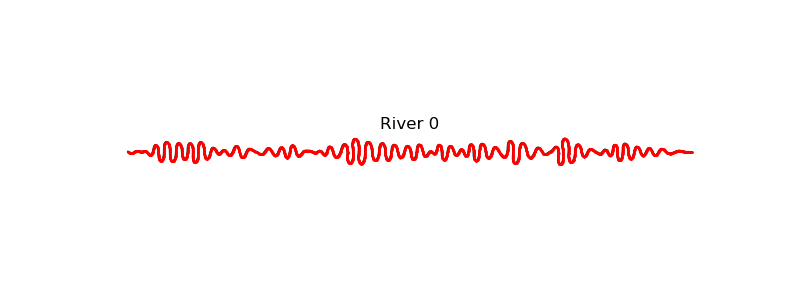

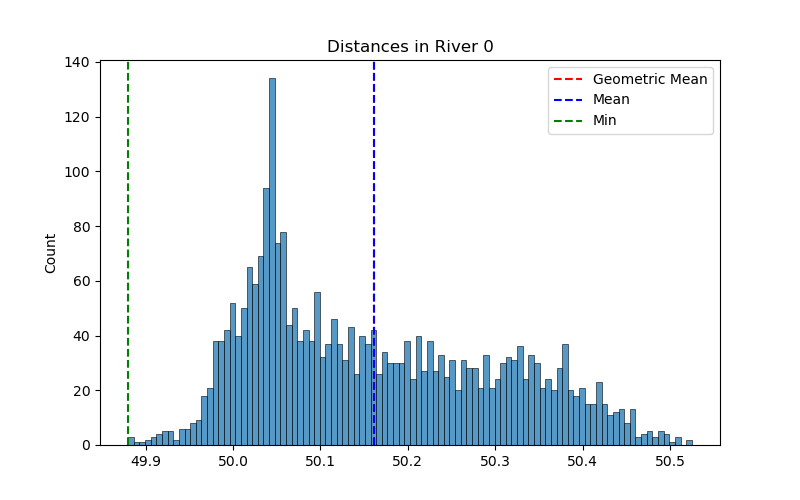

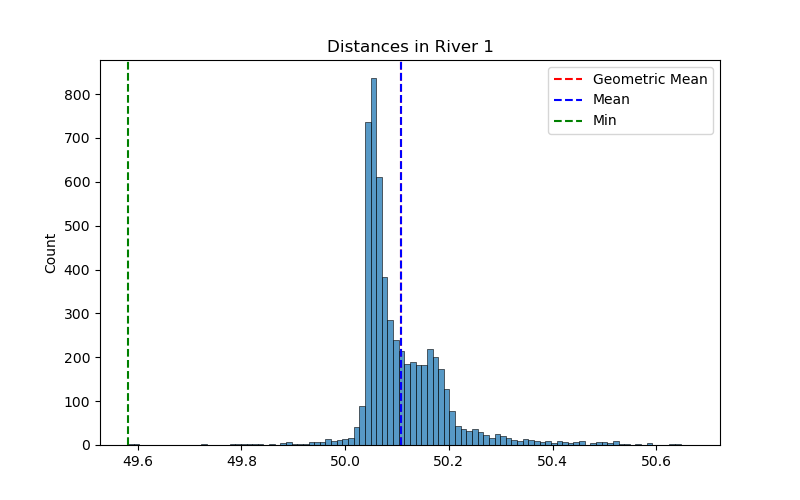

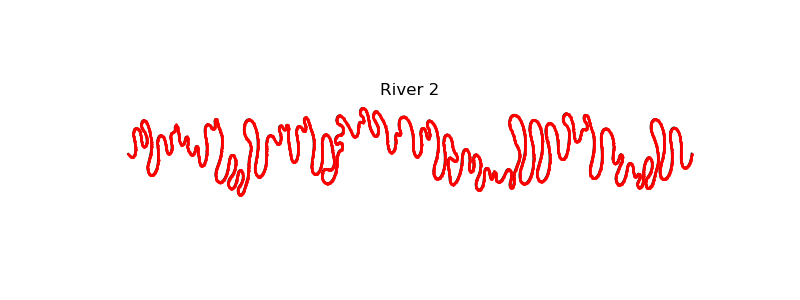

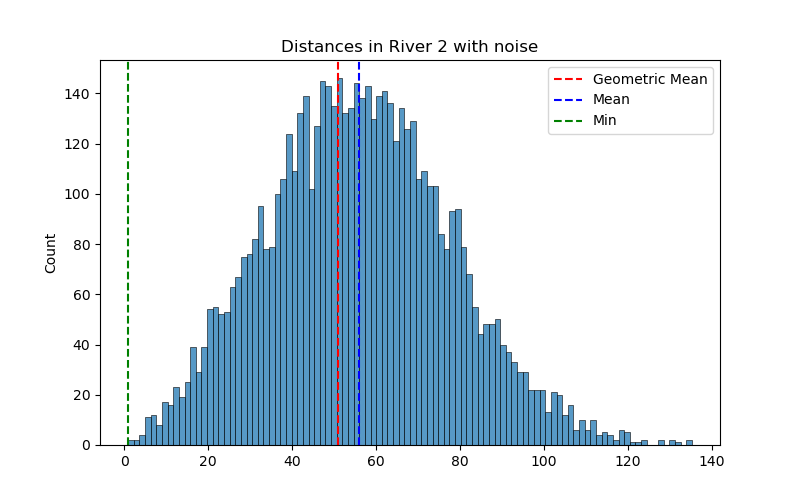

In [4]:
# Load river data
data = FM.load_data('synthetic_rivers/synthetic_rivers_meanderpy.hdf5')
river_ids = list(data.keys())

utl.cr_folder('synthetic_rivers/results')

plt.close('all')

# Loop throug the rivers
for id_river_general in river_ids:
    # ------------------------------
    # Select River to perform analysis
    # ------------------------------
    x_ch = data[id_river_general]['x'][155:-155]
    y_ch = data[id_river_general]['y'][155:-155]
    coords = np.array([x_ch, y_ch]).T
    s_ch = RF.get_reach_distances(coords)
    ds = np.diff(s_ch)
    ds = np.append(ds[0], ds)
    # Curvature original data
    _, c_ch, _ = RF.calculate_curvature(s_ch, x_ch, y_ch)

    # ------------------------------
    # Noise
    # ------------------------------
    # Use a linear model to get a sense of the added noise
    line_model = sm.OLS(y_ch, x_ch).fit()
    sd_resid = np.std(line_model.resid)
    sigma = sd_resid/100
    # Add noise to the coordiantes
    x_ch_noise = x_ch + np.random.normal(0, sigma, size=len(x_ch))
    y_ch_noise = y_ch + np.random.normal(0, sigma, size=len(y_ch))
    coords = np.array([x_ch_noise, y_ch_noise]).T
    s_ch_noise = RF.get_reach_distances(coords)
    ds_noise = np.diff(s_ch_noise)
    ds_noise = np.append(ds_noise[0], ds_noise)

    # ------------------------------
    # Calculate additional variables
    # ------------------------------
    # Width
    w_m = np.ones_like(x_ch) * 200.0

    w_m_gm = 10**np.mean(np.log10(w_m))
    geometric_mean_value = 10**np.mean(np.log10(ds))
    mean_value = np.mean(ds)
    min_value = np.min(ds)

    gm_noise = 10**np.mean(np.log10(ds_noise))
    mean_noise = np.mean(ds_noise)
    min_noise = np.min(ds_noise)
    # ------------------------------
    # Save noisy data
    # ------------------------------
    data[id_river_general]['x'] = x_ch
    data[id_river_general]['y'] = y_ch
    data[id_river_general]['c'] = c_ch
    data[id_river_general]['s'] = s_ch
    data[id_river_general]['ds'] = ds
    data[id_river_general]['x_noise'] = x_ch_noise
    data[id_river_general]['y_noise'] = y_ch_noise
    data[id_river_general]['s_noise'] = s_ch_noise
    data[id_river_general]['w_m'] = w_m

    # ------------------------------
    # Plots
    # ------------------------------
    plt.figure(figsize=(8, 3))
    plt.title(f'River {id_river_general}')
    plt.plot(x_ch, y_ch, '-k')
    plt.plot(x_ch_noise, y_ch_noise, '.r', markersize=1.5)
    plt.gca().set_aspect(2, adjustable='box')
    # Remove ticks
    plt.xticks([])
    plt.yticks([])
    # Remove axis lines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.show()

    data_df = pd.DataFrame({'x': x_ch, 'y': y_ch, 's': s_ch, 'ds': ds,
                            'x_noise': x_ch_noise, 'y_noise': y_ch_noise,
                            's_noise': s_ch_noise, 'c': c_ch,
                            'ds_noise': ds_noise, 'w_m': w_m})
    plt.figure(figsize=(8, 5))
    plt.title(f'Distances in River {id_river_general}')
    sns.histplot(x=ds, bins=100)
    # plt.axvline(w_m_gm, color='k', linestyle='--',
    #             label='Width Geometric Mean')
    plt.axvline(geometric_mean_value, color='r', linestyle='--',
                label='Geometric Mean')
    plt.axvline(mean_value, color='b', linestyle='--', label='Mean')
    plt.axvline(min_value, color='g', linestyle='--', label='Min')
    plt.legend()
    plt.savefig(
        f'synthetic_rivers/results/dist_hist_river_{id_river_general}.png',
        dpi=300)
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.title(f'Distances in River {id_river_general} with noise')
    sns.histplot(x=ds_noise, bins=100)
    # plt.axvline(w_m_gm, color='k', linestyle='--',
    #             label='Width Geometric Mean')
    plt.axvline(gm_noise, color='r', linestyle='--',
                label='Geometric Mean')
    plt.axvline(mean_noise, color='b', linestyle='--', label='Mean')
    plt.axvline(min_noise, color='g', linestyle='--', label='Min')
    plt.legend()
    plt.show()


# Save data
FM.save_data(data, path_output='synthetic_rivers/',
             file_name='synthetic_rivers_w_noise.hdf5')

### Create River Class

We load the coordinates to the `Rivers` class. We use the the geometric mean of the distance to resample the river.

2024-01-19 13:52:01,021[INFO] info: Start Logger in RiverDatasets
2024-01-19 13:52:01,059[INFO] info:  Scaling curvature by width
2024-01-19 13:52:01,061[INFO] info:  Scaling curvature by width
2024-01-19 13:52:01,090[INFO] info:  Scaling curvature by width
2024-01-19 13:52:01,093[INFO] info:  Scaling curvature by width
2024-01-19 13:52:01,173[INFO] info:  Scaling curvature by width
2024-01-19 13:52:01,176[INFO] info:  Scaling curvature by width
2024-01-19 13:52:01,233[INFO] info:  Scaling curvature by width
2024-01-19 13:52:01,237[INFO] info:  Scaling curvature by width
2024-01-19 13:52:01,313[INFO] info:  Scaling curvature by width
2024-01-19 13:52:01,315[INFO] info:  Scaling curvature by width
2024-01-19 13:52:01,371[INFO] info:  Scaling curvature by width
2024-01-19 13:52:01,373[INFO] info:  Scaling curvature by width


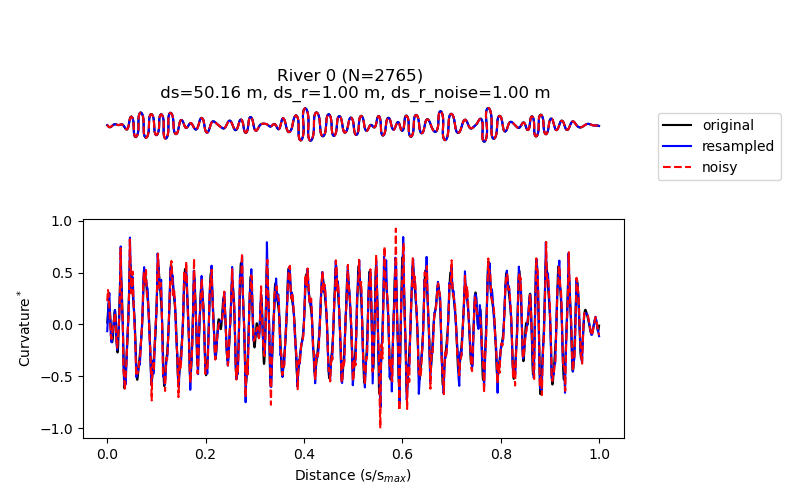

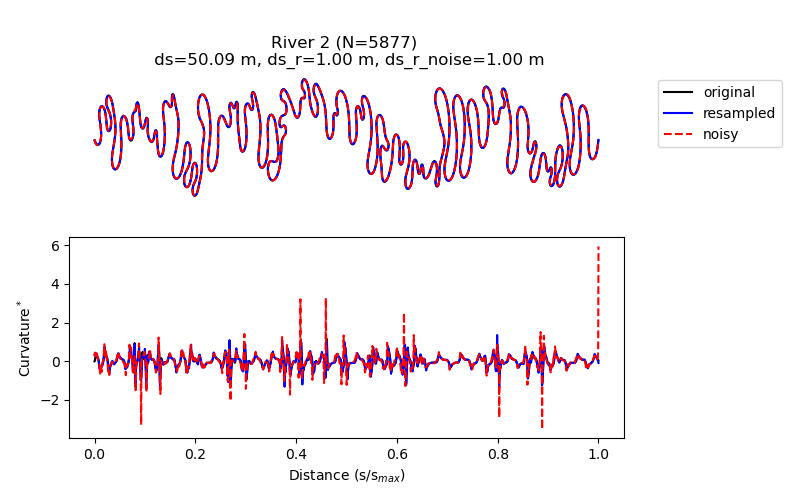

In [5]:
# Reset Figures
plt.close('all')
# Load river data
data = FM.load_data('synthetic_rivers/synthetic_rivers_w_noise.hdf5')
river_ids = list(data.keys())
# ------------------------------
# Arguments for the noise data
# ------------------------------
kwargs_resample = {
    '0':{'smooth': 1e2},
    '1':{'smooth': 1e2},
    '2':{'smooth': 1e2},
    '0_noise':{'smooth': 1e2},
    '1_noise':{'smooth': 1e3},
    '2_noise':{'smooth': 1e3},
    }

# ------------------------------
# Create Rivers class
# ------------------------------
rivers = RiverDatasets(logger=logger)
# ------------------------------
# Add Rives into class
# ------------------------------
i = 0
for river_id in river_ids:
    # ------------------------------
    # Add original river 
    # ------------------------------
    x_ch = data[river_id]['x']
    y_ch = data[river_id]['y']
    w_m = data[river_id]['w_m']
    rivers.add_river(river_id, x_ch, y_ch, w_m=w_m, resample_flag=True,
                     kwargs_resample=kwargs_resample[river_id],
                     scale_by_width=True)
    # Calculate curvature
    rivers[river_id].calculate_curvature()
    # ------------------------------
    # Add noisy river 
    # ------------------------------
    x_ch_noise = data[river_id]['x_noise']
    y_ch_noise = data[river_id]['y_noise']
    w_m = data[river_id]['w_m']
    rivers.add_river(
        f'{river_id}_noise', x_ch_noise, y_ch_noise, w_m=w_m,
        resample_flag=True,
        kwargs_resample=kwargs_resample[f'{river_id}_noise'],
        scale_by_width=True)
    # Calculate cuvature
    rivers[f'{river_id}_noise'].calculate_curvature()

for river_id in river_ids:
    # ------------------------------
    # Plot
    # ------------------------------
    x_ch = data[river_id]['x']
    y_ch = data[river_id]['y']
    c_ch = data[river_id]['c']
    s_ch = data[river_id]['s']
    ds_ch = data[river_id]['ds']
    x = rivers[river_id].x
    y = rivers[river_id].y
    c = rivers[river_id].c
    s = rivers[river_id].s
    ds = rivers[river_id].ds
    x_noise = rivers[f'{river_id}_noise'].x
    y_noise = rivers[f'{river_id}_noise'].y
    c_noise = rivers[f'{river_id}_noise'].c
    s_noise = rivers[f'{river_id}_noise'].s
    ds_noise = rivers[f'{river_id}_noise'].ds

    f, ax = plt.subplots(2, 1, figsize=(8, 5))
    # Plot river
    ax[0].plot(x_ch/w_m_gm, y_ch/w_m_gm, '-k', label='original')
    # ax[0].plot(x_ch, y_ch, '-k', label='original')
    ax[0].plot(x, y, '-b', label='resampled')
    ax[0].plot(x_noise, y_noise, '--r', label='noisy')
    ax[0].set_aspect(3, adjustable='box')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title(
        f'River {river_id} (N={len(x_ch)}) \n ds={np.mean(ds_ch):.2f} m, '
        f'ds_r={ds:.2f} m, '
        f'ds_r_noise={ds_noise:.2f} m')
    # Remove axis lines
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Curvature
    # ax[1].plot(s_ch/np.max(s_ch), c_ch, '-k', label='original')
    ax[1].plot(s_ch/np.max(s_ch), c_ch*w_m_gm, '-k', label='original')
    ax[1].plot(s/np.max(s), c, '-b', label='resampled')
    ax[1].plot(s_noise/np.max(s_noise), c_noise, '--r', label='noisy')
    # if river_id == '0':
    # ax[1].set_ylim([-0.03, 0.03])
    # ax[1].set_ylim([-3, 3])
    ax[1].set_xlabel('Distance (s/s$_{max}$)')
    ax[1].set_ylabel(r'Curvature$^*$')
    plt.tight_layout()
    utl.cr_folder('synthetic_rivers/results/')
    plt.savefig(f'synthetic_rivers/results/river_{river_id}_curvature.png',
                dpi=300)
    plt.show()

# ------------------------------
# Save Rivers
# ------------------------------
# rivers.save_rivers(
#     f'synthetic_rivers/rivers_class/',
#     'river_network.hdf5', save_cwt_info=True)


 ### Multiscale Characterization

 Let's estimate the spectral variables using the Morlet mother vavelet functions...



2024-01-17 08:18:05,040[INFO] info:  Scaling curvature by width


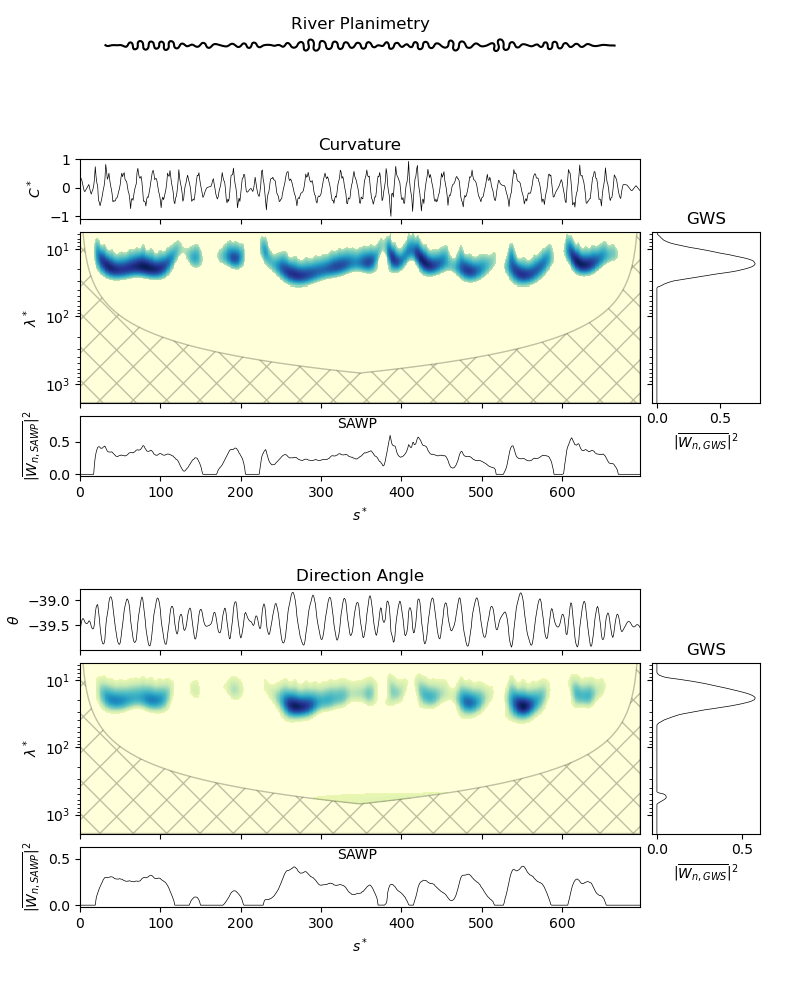

2024-01-17 08:18:06,855[INFO] info:  Scaling curvature by width


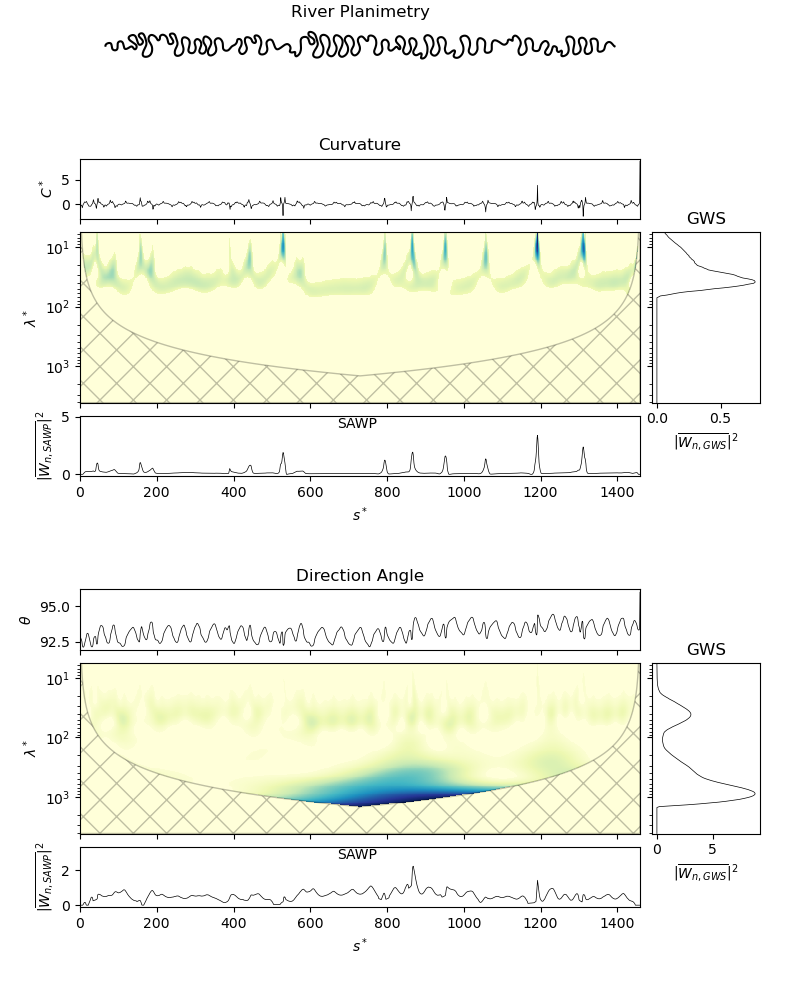

2024-01-17 08:18:08,899[INFO] info:  Scaling curvature by width


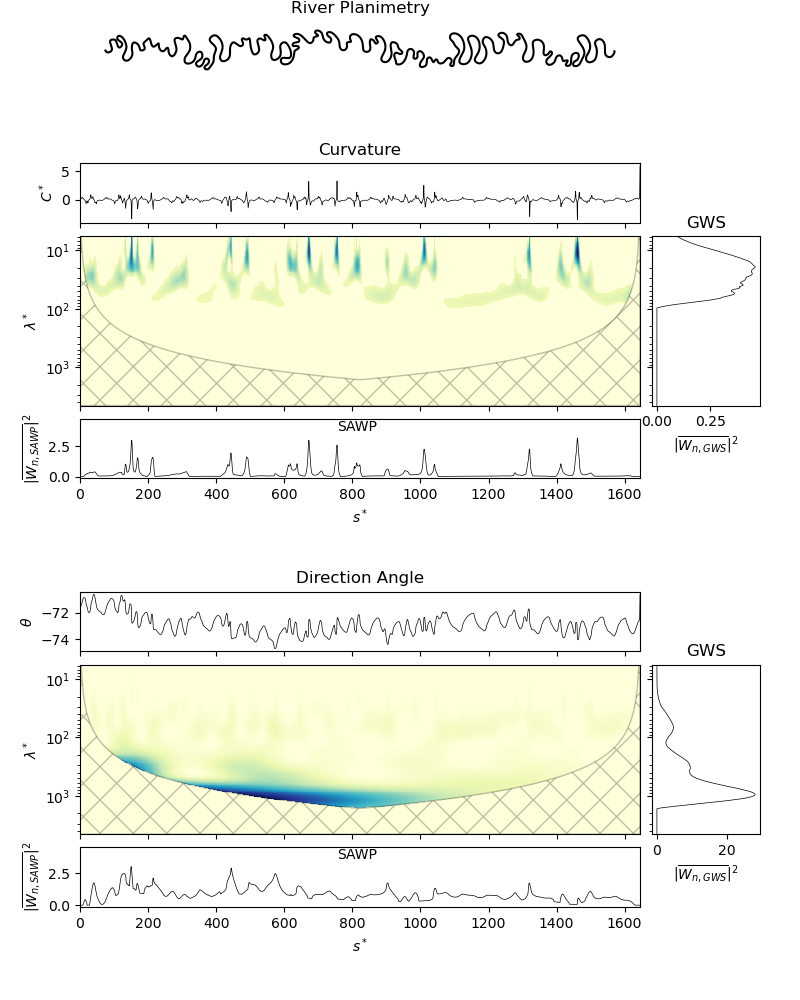

In [9]:
plt.close('all')
for river_id in river_ids:
    # Calculate curvature
    rivers[f'{river_id}_noise'].calculate_curvature()
    # Calculate CWT
    rivers[f'{river_id}_noise'].get_cwt_curvature(mother='MORLET')
    rivers[f'{river_id}_noise'].get_cwt_angle(mother='MORLET')
    graphs.plot_river_spectrum_compiled(rivers[f'{river_id}_noise'],
                                        only_significant=True)
    plt.show()


 ### Extract meanders

 Now that we have a `RiverDatasets` class we can go ahead perform the automated extraction of meanders on the synthetic rivers.

In [6]:
data_to_save = {}
# =================================
# Extract Meanders
# =================================
for river_id in river_ids:
    # =================================
    # Extract Meanders
    # =================================
    # --------------------
    # Calculate Curvature
    # --------------------
    rivers[f'{river_id}'].calculate_curvature()
    rivers[f'{river_id}_noise'].calculate_curvature()
    # --------------------
    # Calculate CWT
    # --------------------
    rivers[f'{river_id}'].extract_cwt_tree()
    rivers[f'{river_id}_noise'].extract_cwt_tree()
    # -----------------------------
    # Prune by peak power
    # -----------------------------
    rivers[f'{river_id}'].prune_tree_by_peak_power()
    rivers[f'{river_id}_noise'].prune_tree_by_peak_power()
    # -----------------------------
    # Prune by sinuosity
    # -----------------------------
    rivers[f'{river_id}'].prune_tree_by_sinuosity(1.05)
    rivers[f'{river_id}_noise'].prune_tree_by_sinuosity(1.05)
    # -----------------------------
    # Add meander to database
    # -----------------------------
    rivers[f'{river_id}'].add_meanders_from_tree_scales(overwrite=True, clip='downstream')
    rivers[f'{river_id}_noise'].add_meanders_from_tree_scales(overwrite=True, clip='downstream')
    # ---------------------------
    # Calculate reach sinuosity
    # ---------------------------
    rivers[f'{river_id}'].calculate_reach_metrics()
    rivers[f'{river_id}_noise'].calculate_reach_metrics()


# ------------------------------
# Save Rivers
# ------------------------------
rivers.save_rivers(
    f'synthetic_rivers/rivers_class_cwt/',
    'river_network.hdf5', save_cwt_info=True)



2024-01-19 13:52:11,483[INFO] info:  Scaling curvature by width
2024-01-19 13:52:11,484[INFO] info:  Scaling curvature by width
2024-01-19 13:52:11,484[INFO] info:   Running CWT...
2024-01-19 13:52:11,504[INFO] info:   Getting the scale tree...
2024-01-19 13:52:11,734[INFO] info:   Finding peaks in CWT...
2024-01-19 13:52:11,765[INFO] info:   Detecting meanders...
2024-01-19 13:52:11,781[INFO] info:   Projecting tree in planimetry...
2024-01-19 13:52:12,200[INFO] info:   Running CWT...
2024-01-19 13:52:12,219[INFO] info:   Getting the scale tree...
2024-01-19 13:52:12,456[INFO] info:   Finding peaks in CWT...
2024-01-19 13:52:12,487[INFO] info:   Detecting meanders...
2024-01-19 13:52:12,503[INFO] info:   Projecting tree in planimetry...
c:\Users\danie\anaconda3\envs\pymeander_env\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\danie\anaconda3\envs\pymeander_env\lib\site-packages\numpy\co

#### Plot the Scale Space Tree

In the following code block we will plot an example of the space scale tree for one of the synthetic rivers. This plot is used in the manuscript as the example of the tree.

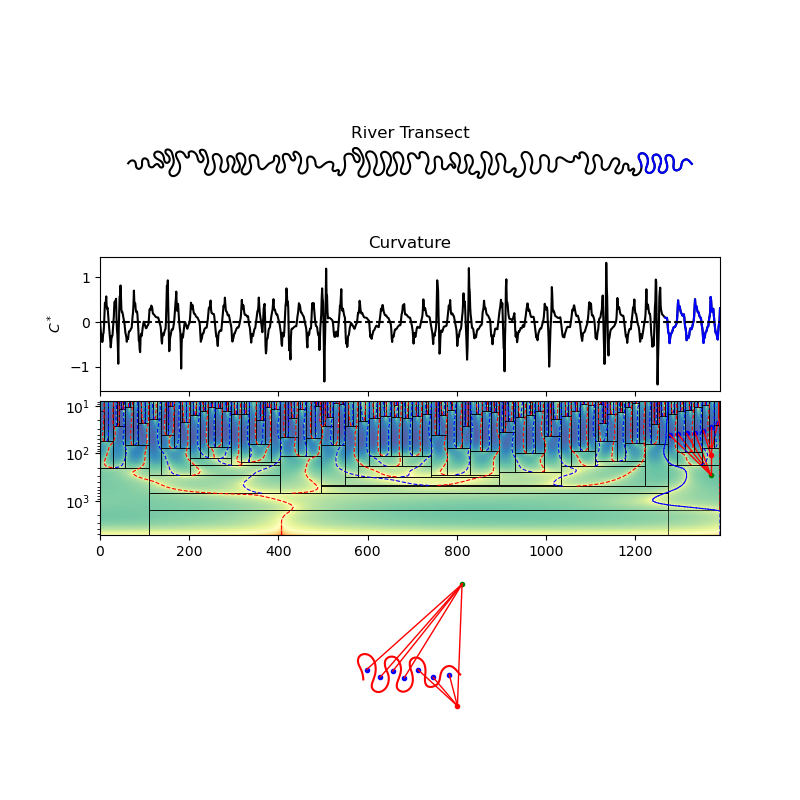

In [7]:
# ========================
# Plot Scale Space Tree
# ========================
# ------------------------
# Extract Information
# ------------------------
id_river = '1'
tree_id = 3
# id_river = '0'
# tree_id = 0
x = rivers[id_river].x
y = rivers[id_river].y
s = rivers[id_river].s
c = rivers[id_river].c
wavelength_c = rivers[id_river].cwt_wavelength_c
power_c = np.log2(rivers[id_river].cwt_power_c)
zc_lines = rivers[id_river].cwt_zc_lines
zc_sign = rivers[id_river].cwt_zc_sign
regions = rivers[id_river].cwt_regions
root_node = rivers[id_river].tree_scales[tree_id]
nodes = [root_node] + list(root_node.descendants)
# ------------------------
# Extract tree info
# ------------------------
idx_st = root_node.idx_leaf_start - 3
idx_end = root_node.idx_leaf_end
x_clip = x[idx_st:idx_end + 1]
y_clip = y[idx_st:idx_end + 1]
s_clip = s[idx_st:idx_end + 1]
c_clip = c[idx_st:idx_end + 1]
# wavelength_c_clip = wavelength_c[idx_st:idx_end + 1]
power_c_clip = power_c[:, idx_st:idx_end + 1]
# ------------------------
# Plot Tree
# ------------------------
kwargs = {'linewidth': 1, 'markersize': 3}
plt.close('all')
f, ax = plt.subplots(4, 1, figsize=(8, 8))
# Plot River Planimetry
ax[0].plot(x, y, '-k')
ax[0].plot(x_clip, y_clip, '-b')
ax[0].set_aspect('equal', adjustable='box')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(f'River Transect')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)
# ax[0].set_xlim([x_clip[0] - 10, x_clip[-1] + 10] )
# ax[0].set_ylim([y_clip.min() - 5, y_clip.max() + 5] )
# Plot curvature
ax[1].plot(s, c, '-k')
ax[1].plot(s_clip, c_clip, '-b')
ax[1].axhline(0, color='k', linestyle='--')
ax[1].set_ylabel(f'$C^*$')
ax[1].set_title(f'Curvature')
ax[1].set_xlim([s[0], s[-1]])
ax[1].set_xticklabels([])

# plot cwt
ax[2].pcolormesh(s, wavelength_c, power_c, cmap='Spectral')
ax[2].set_yscale('log')
ax[2].set_ylim([wavelength_c[-1], wavelength_c[0]])
ax[2].set_xlim(s[0], s[-1])
box = ax[2].get_position()
ax[2].set_position([box.x0, box.y0 + 0.02, box.width, box.height])
# ax[2].set_xlim(s_clip[0], s_clip[-1])

# Re-plot River Planimetry
ax[3].plot(x_clip, y_clip, '-r')
ax[3].set_aspect('equal', adjustable='box')
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].spines['top'].set_visible(False)
ax[3].spines['right'].set_visible(False)
ax[3].spines['bottom'].set_visible(False)
ax[3].spines['left'].set_visible(False)
# Include complete river
# ax[3].plot(x, y, '-k')
# ax[3].set_xlim([x_clip[0] - 10, x_clip[-1] + 10] )
# ax[3].set_ylim([y_clip.min() - 6, y_clip.max() + 5] )

# Plot tree nodes
flags = [True, True, True, True, True, True]
for node in nodes:
    if node.is_meander == 1:
        if flags[0]:
            ax[2].plot(node.s_c, node.wavelength_c, 'ob', label='Leaf Node', **kwargs)
            flags[0] = False
        else:
            ax[2].plot(node.s_c, node.wavelength_c, 'ob', **kwargs)
        ax[3].plot(node.x_c, node.y_c, 'ob', **kwargs)
    elif node.root_node == 1:
        if flags[1]:
            ax[2].plot(node.s_c, node.wavelength_c, 'og', label='Root Node', **kwargs)
            flags[1] = False
        else:
            ax[2].plot(node.s_c, node.wavelength_c, 'og', **kwargs)
        ax[3].plot(node.x_c, node.y_c, 'og', **kwargs)
    else:
        if flags[2]:
            ax[2].plot(node.s_c, node.wavelength_c, 'or', label='Parent Node', **kwargs)
            flags[2] = False
        else:
            ax[2].plot(node.s_c, node.wavelength_c, 'or', **kwargs)
        ax[3].plot(node.x_c, node.y_c, 'or', **kwargs)
    if node.parent is not None:
        if flags[3]:
            ax[2].plot(
                [node.s_c, node.parent.s_c],
                [node.wavelength_c, node.parent.wavelength_c],
                color='r', label='Branches', **kwargs)
            flags[3] = False
        else:
            ax[2].plot(
                [node.s_c, node.parent.s_c],
                [node.wavelength_c, node.parent.wavelength_c],
                color='r', **kwargs)
        ax[3].plot(
            [node.x_c, node.parent.x_c],
            [node.y_c, node.parent.y_c],
            color='r', **kwargs)

# Plot regions
regions_2 = copy.deepcopy(regions)
regions_2[:, 0] = wavelength_c[regions_2[:, 0].astype(int)]
regions_2[:, 1] = wavelength_c[regions_2[:, 1].astype(int)]
regions_2[:, 2] = s[regions_2[:, 2].astype(int)]
regions_2[:, 3] = s[regions_2[:, 3].astype(int)]
columns_1 = np.array([2, 2, 3, 3, 2])
columns_2 = np.array([0, 1, 1, 0, 0])
ax[2].plot(regions_2[:, columns_1].T, regions_2[:, columns_2].T, 'k', lw=0.5,
           label='Region Boundaries')
# Plot zc_lines
for czc, z_c in enumerate(zc_lines):
    if isinstance(z_c, int):
        continue
    if zc_sign[czc] == 1:
        if flags[4]:
            ax[2].plot(
                s[z_c[:, 1]], wavelength_c[z_c[:, 0]], '--r',
                label='+/- ZC-line',
                lw=0.8)
            flags[4] = False
        else:
            ax[2].plot(s[z_c[:, 1]], wavelength_c[z_c[:, 0]], '--r', lw=0.8)
    else:
        if flags[5]:
            ax[2].plot(
                s[z_c[:, 1]], wavelength_c[z_c[:, 0]], '--b',
                label='-/+ ZC-line',
                lw=0.8)
            flags[5] = False
        else:
            ax[2].plot(s[z_c[:, 1]], wavelength_c[z_c[:, 0]], '--b', lw=0.8)

# ax[2].legend()

# Finish plot
# plt.tight_layout()
plt.show()





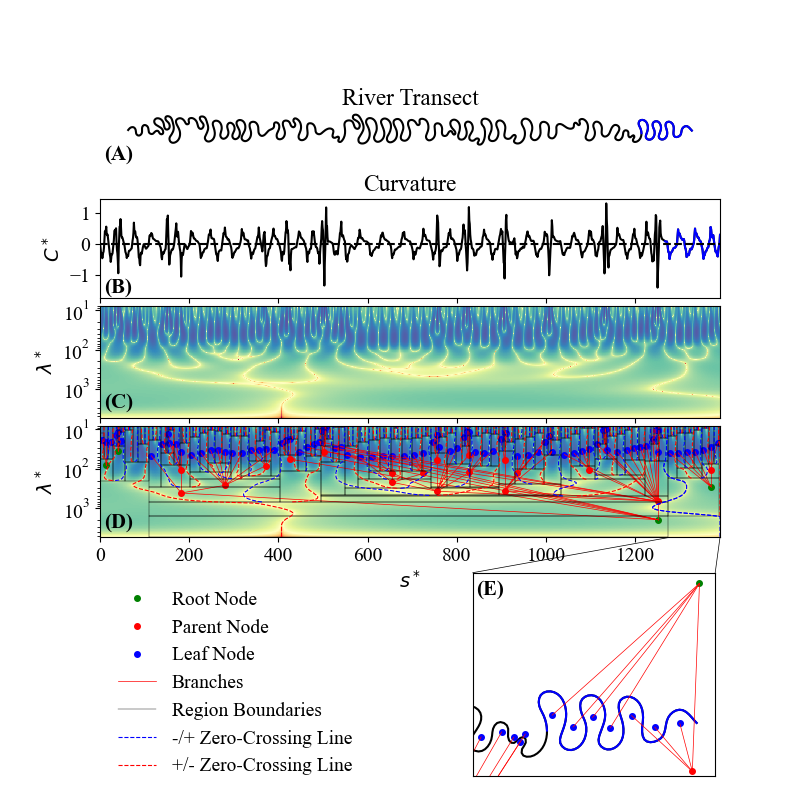

In [109]:
# ========================
# Plot Scale Space Tree
# ========================
# ------------------------
# Extract Information
# ------------------------
id_river = '1'
tree_id = 3
# id_river = '1'
# tree_id = 0
x = rivers[id_river].x
y = rivers[id_river].y
s = rivers[id_river].s
c = rivers[id_river].c
wavelength_c = rivers[id_river].cwt_wavelength_c
power_c = np.log2(rivers[id_river].cwt_power_c)
zc_lines = rivers[id_river].cwt_zc_lines
zc_sign = rivers[id_river].cwt_zc_sign
regions = rivers[id_river].cwt_regions
root_node = rivers[id_river].tree_scales[tree_id]
nodes = [root_node] + list(root_node.descendants)
# ------------------------
# Extract tree info
# ------------------------
idx_st = root_node.idx_leaf_start - 3
idx_end = root_node.idx_leaf_end
x_clip = x[idx_st:idx_end + 1]
y_clip = y[idx_st:idx_end + 1]
s_clip = s[idx_st:idx_end + 1]
c_clip = c[idx_st:idx_end + 1]
# wavelength_c_clip = wavelength_c[idx_st:idx_end + 1]
power_c_clip = power_c[:, idx_st:idx_end + 1]
# ------------------------
# Plot Tree
# ------------------------
fs = 14
mpl.rcParams['font.size'] = fs
mpl.rcParams['font.family'] = 'Times New Roman'
kwargs = {'linewidth': 0.5, 'markersize': 4}
plt.close('all')

f, ax = plt.subplots(5, 1, figsize=(8, 8))
# Plot River Planimetry
ax[0].plot(x, y, '-k')
ax[0].plot(x_clip, y_clip, '-b')
ax[0].set_aspect('equal', adjustable='box')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(f'River Transect')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)

# Plot curvature
ax[1].plot(s, c, '-k')
ax[1].plot(s_clip, c_clip, '-b')
ax[1].axhline(0, color='k', linestyle='--')
ax[1].set_ylabel(f'$C^*$')
ax[1].set_title(f'Curvature')
ax[1].set_xlim([s[0], s[-1]])
ax[1].set_xticklabels([])
ax[1].set_ylim(bottom=np.min(c) - 0.35)

# plot cwt
ax[2].pcolormesh(s, wavelength_c, power_c, cmap='Spectral')
ax[2].set_yscale('log')
ax[2].set_ylim([wavelength_c[-1], wavelength_c[0]])
ax[2].set_xlim(s[0], s[-1])
ax[2].set_xticklabels([])
# ax[2].set_xlim(s_clip[0], s_clip[-1])
ax[2].set_ylabel(f'$\lambda^*$')

ax[3].pcolormesh(s, wavelength_c, power_c, cmap='Spectral')
ax[3].set_yscale('log')
ax[3].set_ylim([wavelength_c[-1], wavelength_c[0]])
ax[3].set_xlim(s[0], s[-1])
# ax[2].set_xlim(s_clip[0], s_clip[-1])
ax[3].set_ylabel(f'$\lambda^*$')
ax[3].set_xlabel(f'$s^*$')

# Re-plot River Planimetry
ax[4].plot(x, y, '-k')
ax[4].plot(x_clip, y_clip, '-b')
ax[4].set_aspect('equal', adjustable='box')
ax[4].set_xticks([])
ax[4].set_yticks([])
# Include complete river
ax[4].set_xlim([x_clip[0] - 20, x_clip[-1] + 5] )
ax[4].set_ylim([y_clip.min() - 7, y_clip.max() + 32] )

# Plot tree nodes
flags = [True, True, True, True, True, True]
tree_ids = list(rivers[id_river].tree_scales.trees)
for tree_id in tree_ids:
    root_node = rivers[id_river].tree_scales[tree_id]
    nodes = [root_node] + list(root_node.descendants)
    for node in nodes:

        if node.is_leaf and not node.is_meander:
            continue
        if node.is_meander == 1:
            if flags[0]:
                ax[3].plot(node.s_c, node.wavelength_c, 'ob', label='Leaf Node', **kwargs)
                flags[0] = False
            else:
                ax[3].plot(node.s_c, node.wavelength_c, 'ob', **kwargs)
            ax[4].plot(node.x_c, node.y_c, 'ob', **kwargs)
        elif node.root_node == 1:
            if flags[1]:
                ax[3].plot(node.s_c, node.wavelength_c, 'og', label='Root Node', **kwargs)
                flags[1] = False
            else:
                ax[3].plot(node.s_c, node.wavelength_c, 'og', **kwargs)
            ax[4].plot(node.x_c, node.y_c, 'og', **kwargs)
        else:
            if flags[2]:
                ax[3].plot(node.s_c, node.wavelength_c, 'or', label='Parent Node', **kwargs)
                flags[2] = False
            else:
                ax[3].plot(node.s_c, node.wavelength_c, 'or', **kwargs)
            ax[4].plot(node.x_c, node.y_c, 'or', **kwargs)
        if node.parent is not None:
            if flags[3] and flags[0] == False and flags[1] == False and flags[2] == False:
                ax[3].plot(
                    [node.s_c, node.parent.s_c],
                    [node.wavelength_c, node.parent.wavelength_c],
                    color='r', label='Branches', **kwargs)
                flags[3] = False
            else:
                ax[3].plot(
                    [node.s_c, node.parent.s_c],
                    [node.wavelength_c, node.parent.wavelength_c],
                    color='r', **kwargs)
            ax[4].plot(
                [node.x_c, node.parent.x_c],
                [node.y_c, node.parent.y_c],
                color='r', **kwargs)

# Plot regions
regions_2 = copy.deepcopy(regions)
regions_2[:, 0] = wavelength_c[regions_2[:, 0].astype(int)]
regions_2[:, 1] = wavelength_c[regions_2[:, 1].astype(int)]
regions_2[:, 2] = s[regions_2[:, 2].astype(int)]
regions_2[:, 3] = s[regions_2[:, 3].astype(int)]
columns_1 = np.array([2, 2, 3, 3, 2])
columns_2 = np.array([0, 1, 1, 0, 0])
ax[3].plot(regions_2[1, columns_1].T, regions_2[1, columns_2].T, 'k', lw=0.3,
           label='Region Boundaries')
ax[3].plot(regions_2[2:, columns_1].T, regions_2[2:, columns_2].T, 'k', lw=0.3)
# Plot zc_lines
for czc, z_c in enumerate(zc_lines):
    if isinstance(z_c, int):
        continue
    if zc_sign[czc] == 1:
        if flags[4]:
            ax[3].plot(
                s[z_c[:, 1]], wavelength_c[z_c[:, 0]], '--r',
                label='+/- Zero-Crossing Line',
                lw=0.8)
            flags[4] = False
        else:
            ax[3].plot(s[z_c[:, 1]], wavelength_c[z_c[:, 0]], '--r', lw=0.8)
    else:
        if flags[5]:
            ax[3].plot(
                s[z_c[:, 1]], wavelength_c[z_c[:, 0]], '--b',
                label='-/+ Zero-Crossing Line',
                lw=0.8)
            flags[5] = False
        else:
            ax[3].plot(s[z_c[:, 1]], wavelength_c[z_c[:, 0]], '--b', lw=0.8)

plt.subplots_adjust(bottom=0.18, top=0.9)
# Move things around
box = ax[2].get_position()
ax[2].set_position([box.x0, box.y0, box.width, box.height + 0.015])
box = ax[3].get_position()
ax[3].set_position([box.x0, box.y0, box.width, box.height + 0.015])
box = ax[4].get_position()
ax[4].set_position([
    box.x0 + 0.13, box.y0 - 0.15, box.width + 0.2, box.height + 0.13])

box = ax[4].get_position()
x_box = [box.x0, box.x0 + 0.245]
y_box = [box.y0 + box.height, box.y0 + box.height + 0.044]
plt.plot(x_box, y_box, '-k', lw=0.5, transform=f.transFigure, clip_on=False)
x_box = [box.x0 + box.width, box.x0 + box.width + 0.006]
y_box = [box.y0 + box.height, box.y0 + box.height + 0.044]
plt.plot(x_box, y_box, '-k', lw=0.5, transform=f.transFigure, clip_on=False)

# Include legend in 3
ax[3].legend(bbox_to_anchor=(0, -2.3), loc='lower left', frameon=False)

# Text
f.text(0.13, 0.8, f'(A)', fontsize=15, fontweight='bold')
f.text(0.13, 0.634, f'(B)', fontsize=15, fontweight='bold')
f.text(0.13, 0.49, f'(C)', fontsize=15, fontweight='bold')
f.text(0.13, 0.34, f'(D)', fontsize=15, fontweight='bold')
f.text(0.595, 0.257, f'(E)', fontsize=15, fontweight='bold')
# Finish plot
# ax[2].legend()
# plt.tight_layout()
utl.cr_folder('../manuscript_figures/')
plt.savefig('../manuscript_figures/Figure_03_Automated_Process.png', dpi=500,
            bbox_inches='tight')
plt.show()

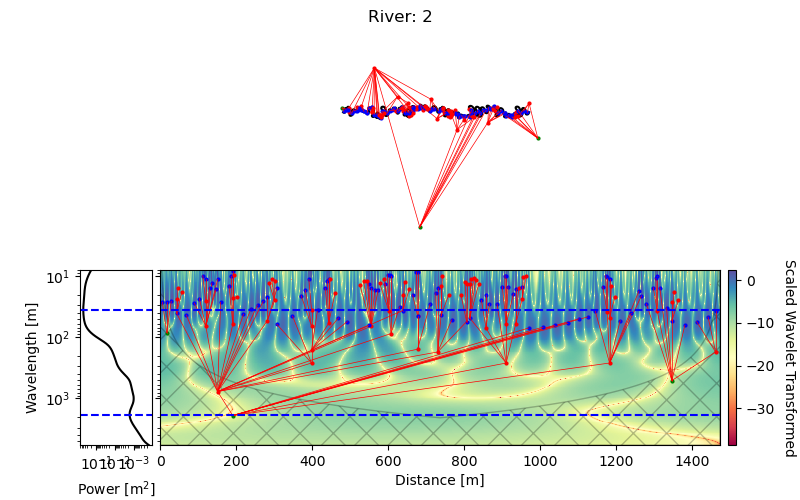

In [155]:
id_river = '2'
rivers[id_river].plot_tree_nodes(markersize=2, linewidth=0.5)
# rivers[id_river].plot_tree_nodes(markersize=2, linewidth=0.5, tree_ids=0)

### Explore the Network

In the following code blocks we will show how to explore the current network with the information gathered from the characterization of meanders. Let's start by loading the information and looking at the tree structure found in the spectrum of the curvature of the river network.

In [8]:
# Load Last Rivers obtained
rivers = RiverDatasets(logger=logger)
path_to_load = f'synthetic_rivers/rivers_class_cwt/'
rivers.load_river_network(
    f'{path_to_load}river_network.hdf5',
    fn_tree_scales=f'{path_to_load}tree_scales.p',
    fn_meanders_database=f'{path_to_load}meander_database.csv',
    resample_flag=True)

2023-10-26 09:57:09,961[INFO] info: Start Logger in Rivers
2023-10-26 09:57:10,298[INFO] info: Resample calculated with `River.calculate_spline()`
2023-10-26 09:57:10,614[INFO] info: Resample calculated with `River.calculate_spline()`
2023-10-26 09:57:10,961[INFO] info: Resample calculated with `River.calculate_spline()`
2023-10-26 09:57:11,365[INFO] info: Resample calculated with `River.calculate_spline()`
2023-10-26 09:57:11,811[INFO] info: Resample calculated with `River.calculate_spline()`
2023-10-26 09:57:12,231[INFO] info: Resample calculated with `River.calculate_spline()`
2023-10-26 09:57:12,903[INFO] info: Resample calculated with `River.calculate_spline()`
2023-10-26 09:57:13,400[INFO] info: Resample calculated with `River.calculate_spline()`


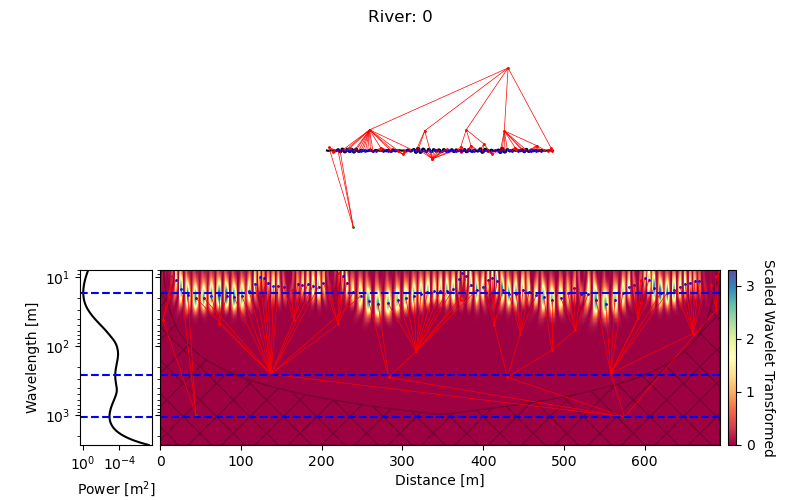

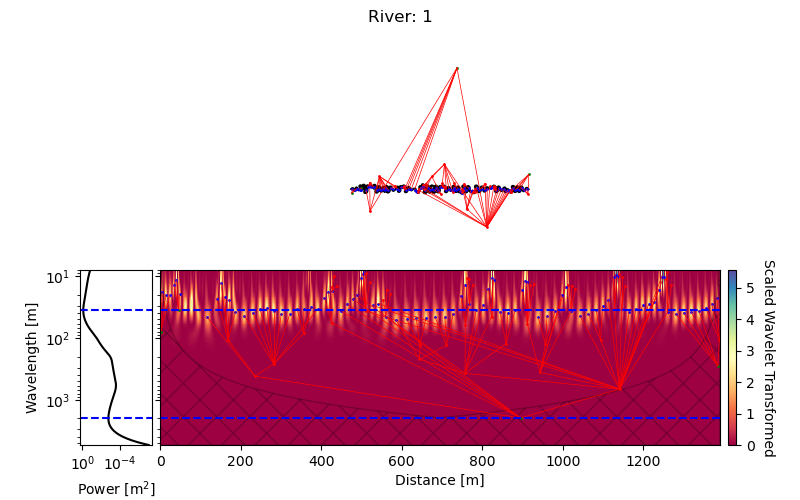

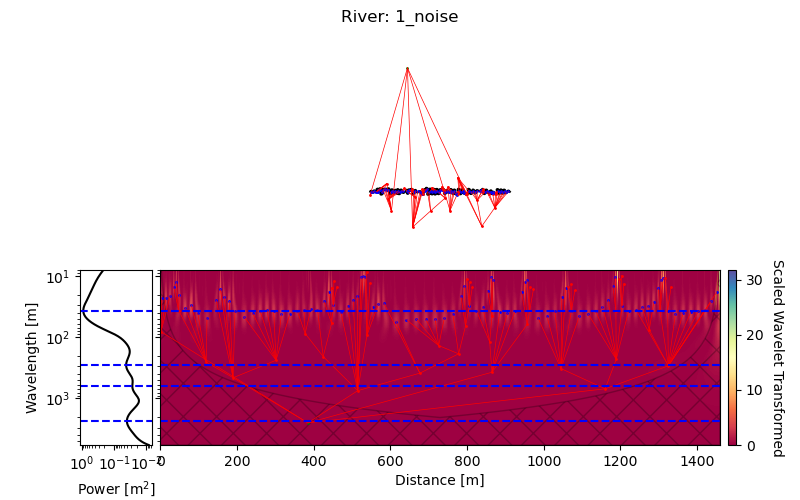

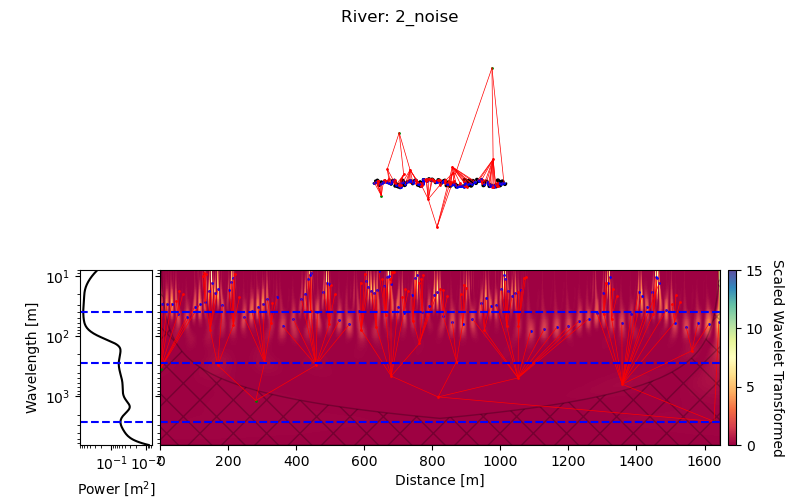

In [16]:
# Plor Rivers node tree
plt.close('all')
river_ids = rivers['id_values']
river_ids = np.sort(river_ids)
for river_id in river_ids:
    rivers[river_id].plot_tree_nodes(markersize=1, linewidth=0.5)
    utl.cr_folder('synthetic_rivers/results/cwt/')
    plt.savefig(f'synthetic_rivers/results/cwt/river_{river_id}_all.png',
                dpi=300)
    plt.show()


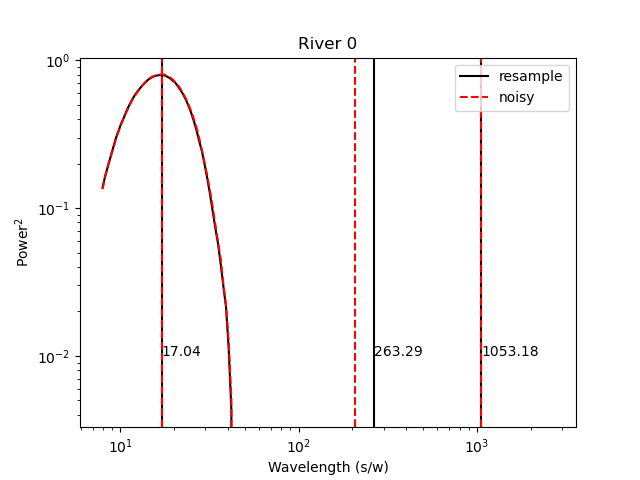

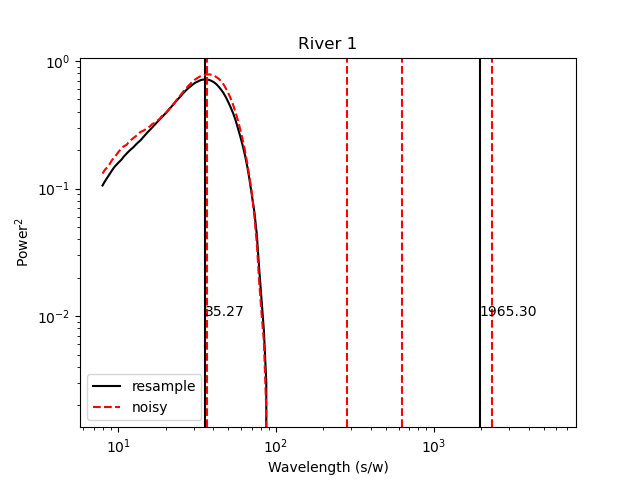

In [24]:
# Plot comparison of GWS
river_ids_2 = ['0', '1', '2']
for river_id in river_ids_2:
    gws = rivers[river_id].cwt_gws_c_sig
    peak_gws_wavelength = rivers[river_id].cwt_gws_peak_wavelength_c
    gws_noise = rivers[f'{river_id}_noise'].cwt_gws_c_sig
    peak_gws_wavelength_noise = rivers[f'{river_id}_noise'].cwt_gws_peak_wavelength_c
    wavelength = rivers[river_id].cwt_wavelength_c
    wavelength_noise = rivers[f'{river_id}_noise'].cwt_wavelength_c
    plt.figure()
    plt.title(f'River {river_id}')
    plt.plot(wavelength, gws, '-k', label='resample')
    for peak in peak_gws_wavelength:
        plt.axvline(peak, color='k', linestyle='-')
        # Annotate peak value
        plt.annotate(f'{peak:.2f}', (peak, 1e-2))
    plt.plot(wavelength_noise, gws_noise, '--r', label='noisy')
    for peak in peak_gws_wavelength_noise:
        plt.axvline(peak, color='r', linestyle='--')
        # annotate peak value
        plt.annotate(f'{peak:.2f}', (peak, 1e-3), color='r')
    plt.xlabel('Wavelength (s/w)')
    plt.ylabel(f'Power$^2$')
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')
    plt.legend()
    utl.cr_folder('synthetic_rivers/results/cwt/')
    plt.savefig(f'synthetic_rivers/results/cwt/river_{river_id}_gws.png',
                dpi=300)
    plt.show()

### Analysis per tree


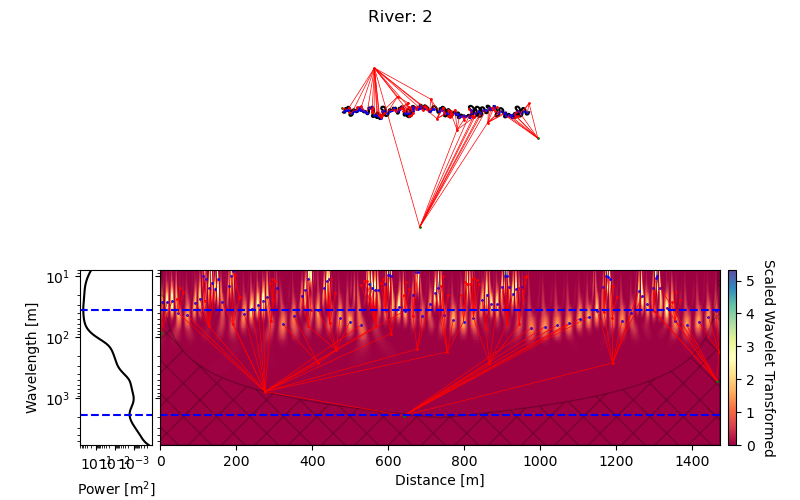

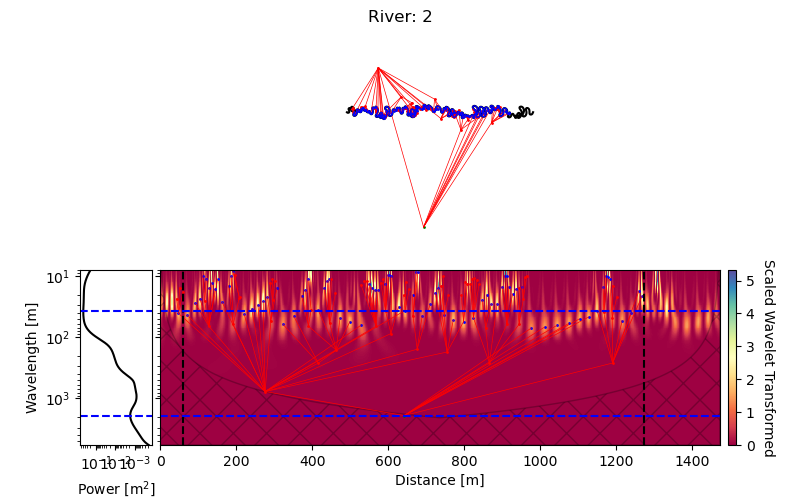

In [26]:
rivers['2'].plot_tree_nodes(markersize=1, linewidth=0.5)
rivers['2'].plot_tree_nodes(tree_ids=1, markersize=1, linewidth=0.5)

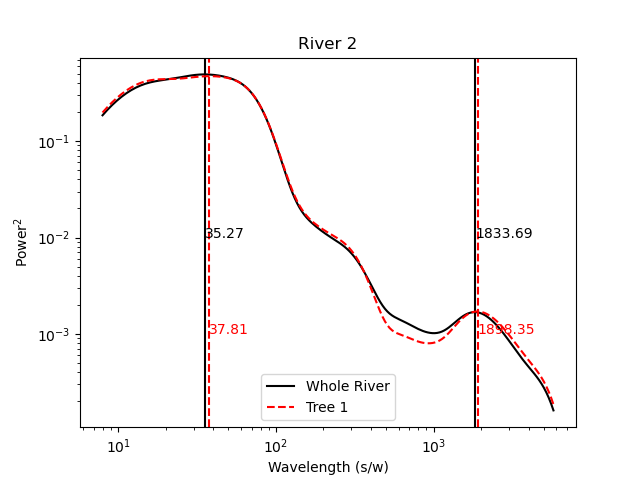

In [11]:
river_id = '2'
tree_id = 1

gws = rivers[river_id].cwt_gws_c
peak_gws_wavelength = rivers[river_id].cwt_gws_peak_wavelength_c
gws_noise = rivers[f'{river_id}'].tree_scales[tree_id].gws
peak_gws_wavelength_noise = rivers[f'{river_id}'].tree_scales[tree_id].gws_peak_wavelength
wavelength = rivers[river_id].cwt_wavelength_c
plt.figure()
plt.title(f'River {river_id}')
plt.plot(wavelength, gws, '-k', label='Whole River')
for peak in peak_gws_wavelength:
    plt.axvline(peak, color='k', linestyle='-')
    # Annotate peak value
    plt.annotate(f'{peak:.2f}', (peak, 1e-2))
plt.plot(wavelength, gws_noise, '--r', label=f'Tree {tree_id}')
for peak in peak_gws_wavelength_noise:
    plt.axvline(peak, color='r', linestyle='--')
    # annotate peak value
    plt.annotate(f'{peak:.2f}', (peak, 1e-3), color='r')
plt.xlabel('Wavelength (s/w)')
plt.ylabel(f'Power$^2$')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.legend()
utl.cr_folder('synthetic_rivers/results/closer_look/')
plt.savefig(f'synthetic_rivers/results/closer_look/river_{river_id}_gws.png',
            dpi=300)
plt.show()

In [12]:
# Plot tree with inflection points
river_id = '2'
# river_id = '3'
tree_id = 1
x_all = rivers[river_id].x
y_all = rivers[river_id].y
x = rivers[river_id].x
y = rivers[river_id].y
c = rivers[river_id].c
s_all = rivers[river_id].s
root_node = rivers[river_id].tree_scales[tree_id]
idx_st = root_node.idx_leaf_start
idx_end = root_node.idx_leaf_end
x = x[idx_st:idx_end]
y = y[idx_st:idx_end]
c = c[idx_st:idx_end]
s = s_all[idx_st:idx_end]
# database = rivers[river_id].tree_scales_database_meanders
# subdatabase = database[database['tree_id'] == tree_id]
# idx_inf_start = subdatabase['idx_planimetry_start'].values
# idx_inf_end = subdatabase['idx_planimetry_end'].values
database = rivers[river_id].database
subdatabase = database[database['tree_id'] == tree_id]
x_inf_start = subdatabase['x_start'].values
x_inf_end = subdatabase['x_end'].values
y_inf_start = subdatabase['y_start'].values
y_inf_end = subdatabase['y_end'].values
s_inf_start = subdatabase['s_start'].values
s_inf_end = subdatabase['s_end'].values

# Get lines for metrics
# Starting and ending point
d = np.array([[x[0], y[0]], [x[-1], y[-1]]])
# Hal-meander distance Y_k
# y_k = np.array([[x_all[idx_inf_start], y_all[idx_inf_start]],
#                 [x_all[idx_inf_end], y_all[idx_inf_end]]])
y_k = np.array([[x_inf_start, y_inf_start],
                [x_inf_end, y_inf_end]])
# Full meander distance X_j
n = subdatabase.shape[0]
i_start = np.arange(0, n - 1, 2)

subset_database = rivers[river_id].database[rivers[river_id].database['tree_id'] == tree_id]
x_f_m = subset_database['x_start'].values[i_start]
y_f_m = subset_database['y_start'].values[i_start]
x_f_m = np.hstack((x_f_m, subset_database['x_end'].values[-1]))
y_f_m = np.hstack((y_f_m, subset_database['y_end'].values[-1]))
x_j = np.array([x_f_m, y_f_m]).T


utl.cr_folder('synthetic_rivers/results/closer_look/')
# plot
# TODO: Include this plot in graphs.py with plotly functionallity!
plt.close('all')
plt.figure(figsize=(8, 5))
plt.plot(x, y, '-k')
# plot inflection points
plt.plot(x_inf_start, y_inf_start, 'or', label='Inflections Start')
plt.plot(x_inf_end, y_inf_end, '.b', label='Inlfections End')
# plot D
plt.plot(d[:, 0], d[:, 1], '--r', label='D')
# plot y_k
plt.plot([y_k[0, 0, 0], y_k[1, 0, 0]], [y_k[0, 1, 0], y_k[1, 1, 0]], '--b', label='Y_k')
plt.plot(y_k[:, 0], y_k[:, 1], '--b')
# plot x_j
plt.plot(x_j[:, 0], x_j[:, 1], '--g', label='X_j')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(
    f'synthetic_rivers/results/closer_look/river_{river_id}_tree_{tree_id}_inflections.png',
    dpi=300)

plt.show()

# plot curvature
plt.figure(figsize=(8, 5))
plt.plot(s, c, '-k')
# plot inflection points
for i in range(len(s_inf_start)):
    plt.axvline(s_inf_start[i], color='r', linestyle='--', label='Inflections Start',
                linewidth=2)
    plt.axvline(s_inf_end[i], color='b', linestyle='--', label='Inlfections End')
plt.axhline(0, color='k', linestyle='-')
plt.savefig(
    f'synthetic_rivers/results/closer_look/c_{river_id}_tree_{tree_id}_inflections.png',
    dpi=300)
plt.show()


# plt.figure(figsize=(8, 5))
# plt.plot(x, y, '-k')
# # plot inflection points
# plt.plot(x_all[idx_inf_start], y_all[idx_inf_start], 'or', label='Inflections Start')
# plt.plot(x_all[idx_inf_end], y_all[idx_inf_end], '.b', label='Inlfections End')

# plt.gca().set_aspect('equal', adjustable='box')
# # remove axis
# plt.xticks([])
# plt.yticks([])
# # Remove axis lines
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.savefig(
#     f'synthetic_rivers/results/closer_look/river_{river_id}_tree_{tree_id}_inflections_clean.png',
#             dpi=300)

# plt.show()


### Estimate Reach metrics

The package contains routines that allow the characterization of metrics at a reach scale. All of the information related to the tree is store in the `River.tree_scales` attribute. 

c:\Users\danie\anaconda3\envs\pymeander_env\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['M']
  warnings.warn(msg, ValueWarning)


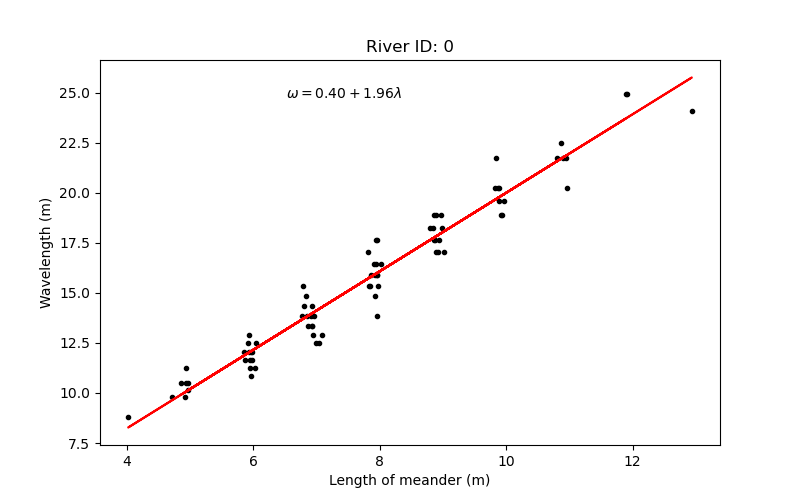

c:\Users\danie\anaconda3\envs\pymeander_env\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['M']
  warnings.warn(msg, ValueWarning)


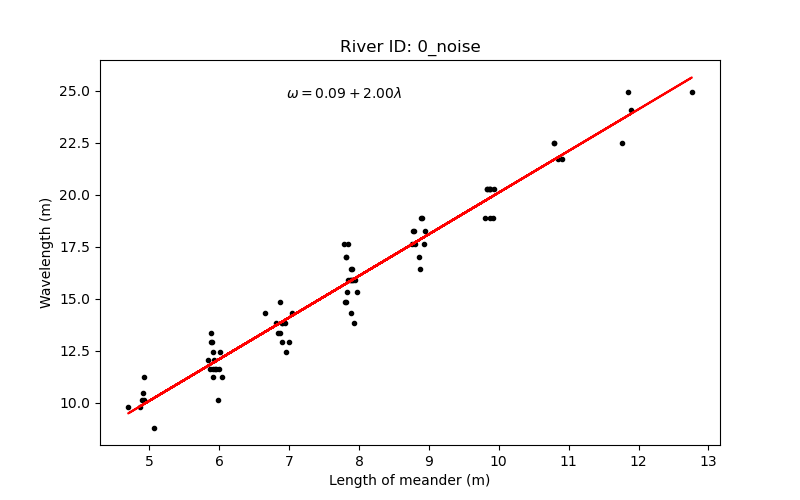

c:\Users\danie\anaconda3\envs\pymeander_env\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['M']
  warnings.warn(msg, ValueWarning)


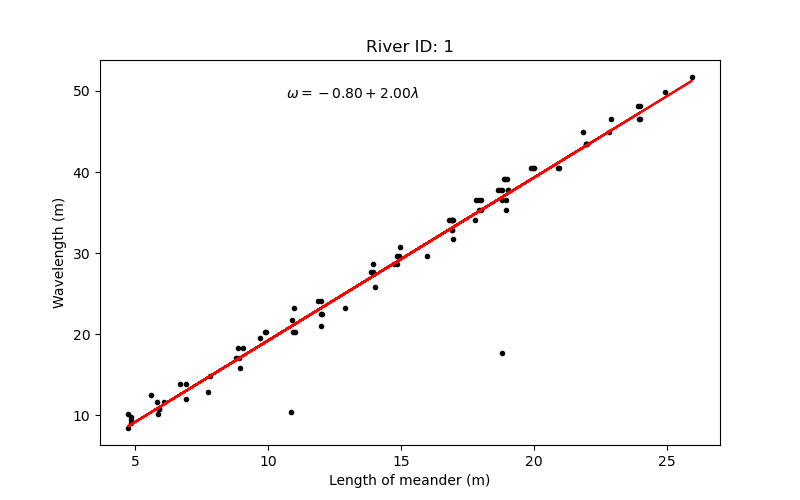

c:\Users\danie\anaconda3\envs\pymeander_env\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['M']
  warnings.warn(msg, ValueWarning)


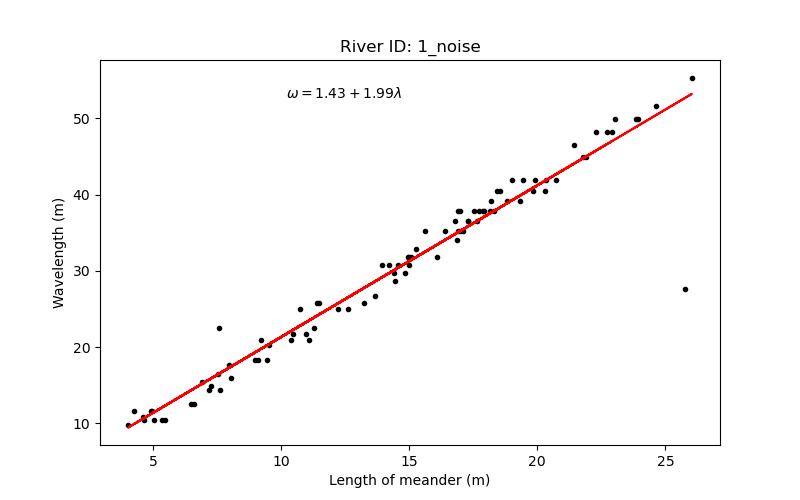

c:\Users\danie\anaconda3\envs\pymeander_env\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['M']
  warnings.warn(msg, ValueWarning)


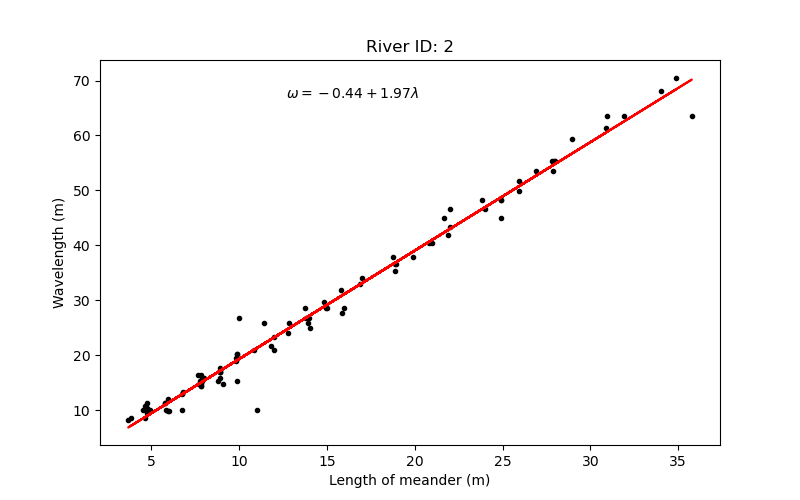

c:\Users\danie\anaconda3\envs\pymeander_env\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['M']
  warnings.warn(msg, ValueWarning)


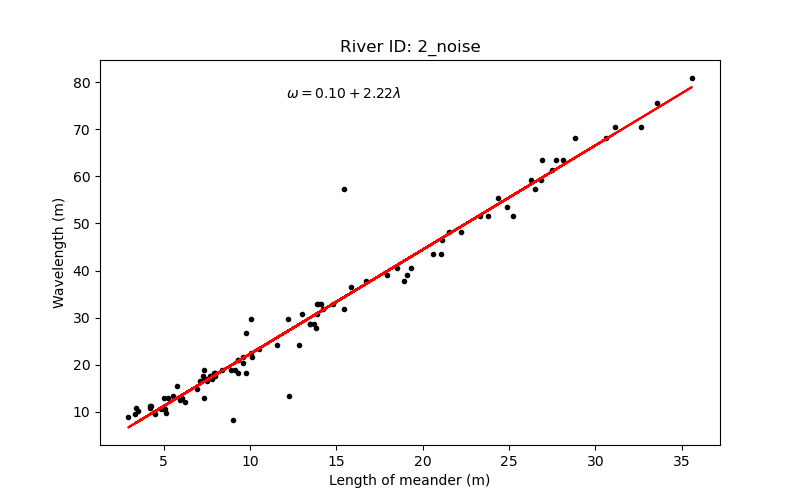

Done


In [14]:
# Look into relationships between wavelength and the length of the meander
river_ids = rivers['id_values']
plt.close('all')
for river_id in river_ids:
# river_id = '2'
    database_meander = rivers[river_id].tree_scales_database_meanders

    wavelength_c = database_meander['wavelength_c'].values
    lambda_value = database_meander['lambda_value'].values

    # Find line of with statsmodels
    import statsmodels.api as sm
    x = lambda_value
    y = wavelength_c
    res_sm_fit = sm.OLS(y, sm.add_constant(x), M=sm.robust.norms.HuberT()).fit()
    y_pred = res_sm_fit.params[0] + res_sm_fit.params[1]*x

    plt.figure(figsize=(8, 5))
    plt.title(f'River ID: {river_id}')
    plt.plot(x, y, '.k')
    plt.plot(lambda_value, y_pred, '-r')
    plt.xlabel('Length of meander (m)')
    plt.ylabel('Wavelength (m)')
    plt.text(
        0.3, 0.9,
        f'$\\omega = {res_sm_fit.params[0]:.2f}+{{{res_sm_fit.params[1]:.2f}}}\\lambda$',
        transform=plt.gca().transAxes)
    plt.show()

print('Done')

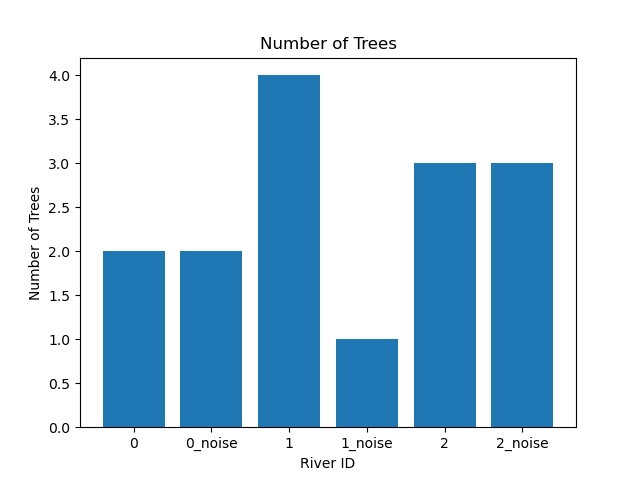

In [15]:
# Number of trees with respect to River
river_ids = rivers['id_values']
river_ids = np.sort(river_ids)
n_trees = []
for river_id in river_ids:
    n_trees.append(len(rivers[river_id].tree_scales.trees))

plt.figure()
plt.title('Number of Trees')
plt.bar(river_ids, n_trees)
plt.xlabel('River ID')
plt.ylabel('Number of Trees')
plt.savefig(f'synthetic_rivers/results/cwt/n_trees.png',
            dpi=300)
plt.show()

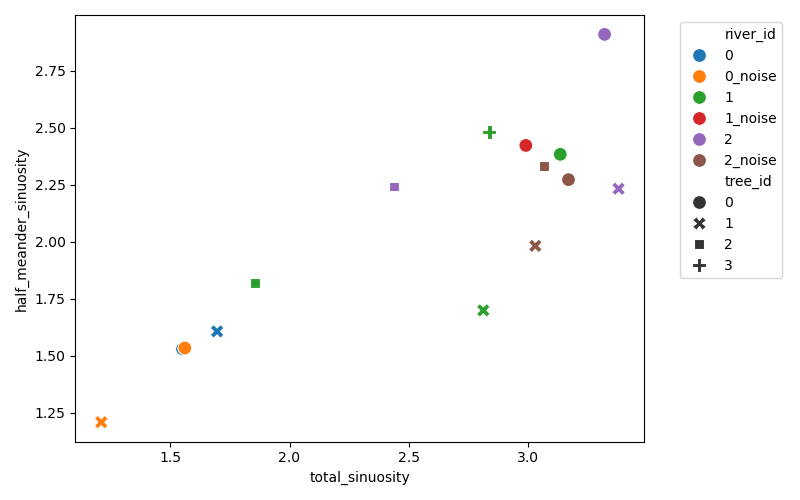

In [16]:
# Extract metrics with noise
river_ids = rivers['id_values']
river_ids = np.sort(river_ids)
variables = ['river_id', 'tree_id', 'total_sinuosity', 'half_meander_sinuosity',
             'full_meander_sinuosity','residual_meander_sinuosity',
             'mean_half_meander_length']
metrics = {v: [] for v in variables}
for river_id in river_ids:
    metrics_reach = rivers[river_id].metrics_reach
    river_id_r = [river_id] * len(metrics_reach['tree_id'])
    metrics['river_id'] += river_id_r
    for v in variables[1:]:
        metrics[v] += metrics_reach[v]

metrics = pd.DataFrame(metrics)
metrics.head()

fig = plt.figure(figsize=(8, 5))
sns.scatterplot(data=metrics, x='total_sinuosity', y='half_meander_sinuosity',
                hue='river_id', style='tree_id', s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'synthetic_rivers/results/cwt/sinuosity_comparison_1.png',
            dpi=300)
plt.show()

fig = plt.figure(figsize=(8, 5))
sns.scatterplot(data=metrics, x='mean_half_meander_length', y='half_meander_sinuosity',
                hue='river_id', style='tree_id', s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'synthetic_rivers/results/cwt/sinuosity_comparison_2.png',
            dpi=300)
plt.show()


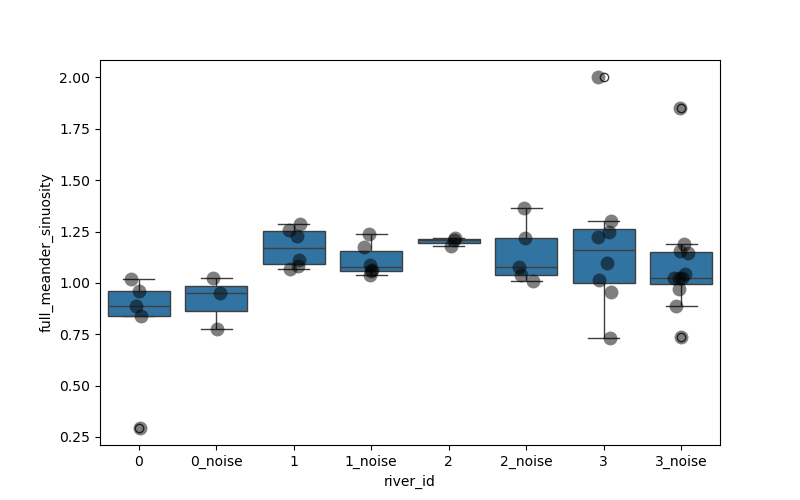

In [22]:

river_ids = rivers['id_values']
river_ids = np.sort(river_ids)
variables = ['river_id', 'tree_id', 'total_sinuosity', 'half_meander_sinuosity',
             'full_meander_sinuosity','residual_meander_sinuosity',
             'mean_half_meander_length']
metrics = {v: [] for v in variables}
for river_id in river_ids:
    metrics_reach = rivers[river_id].metrics_reach
    river_id_r = [river_id] * len(metrics_reach['tree_id'])
    metrics['river_id'] += river_id_r
    for v in variables[1:]:
        metrics[v] += metrics_reach[v]

metrics = pd.DataFrame(metrics)
metrics.head()

# plot boxplots using seabon
plt.figure(figsize=(8, 5))
sns.boxplot(data=metrics, x='river_id', y='half_meander_sinuosity',
            )
# add the amount of data points used to calculate the boxplot
sns.stripplot(data=metrics, x='river_id', y='half_meander_sinuosity',
              color='k', size=10, alpha=0.5)
plt.savefig(f'synthetic_rivers/results/cwt/sinuosity_comparison_3.png',
            dpi=300)
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=metrics, x='river_id', y='mean_half_meander_length',
            )
# add the amount of data points used to calculate the boxplot
sns.stripplot(data=metrics, x='river_id', y='mean_half_meander_length',
              color='k', size=10, alpha=0.5)
plt.savefig(f'synthetic_rivers/results/cwt/sinuosity_comparison_4.png',
            dpi=300)
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=metrics, x='river_id', y='full_meander_sinuosity',
            )
# add the amount of data points used to calculate the boxplot
sns.stripplot(data=metrics, x='river_id', y='full_meander_sinuosity',
              color='k', size=10, alpha=0.5)
plt.savefig(f'synthetic_rivers/results/cwt/sinuosity_comparison_5.png',
            dpi=300)
plt.show()



### Estimate Metrics for Meanders

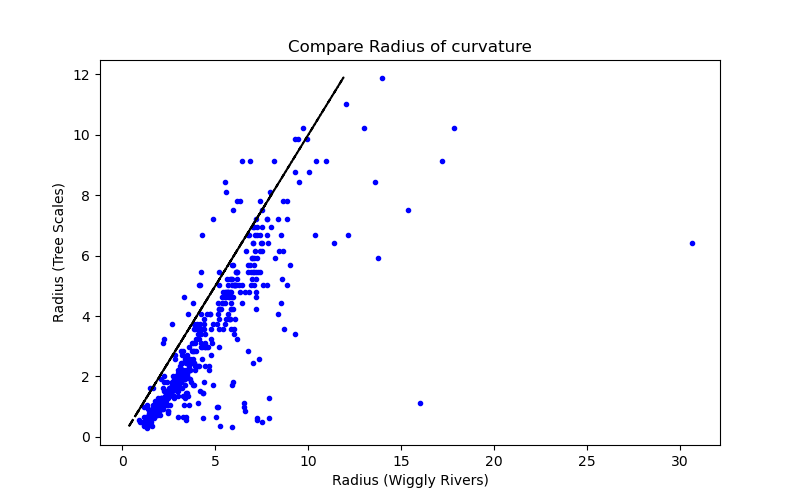

In [18]:
# Metrics for meanders
river_ids = rivers['id_values']
river_ids = np.sort(river_ids)
for river_id in river_ids:
    if river_id == '0':
        ts_database_meanders = rivers[river_id].tree_scales_database_meanders
    else:
        ts_database_meanders = pd.concat(
            [ts_database_meanders,
             rivers[river_id].tree_scales_database_meanders])

ts_database_meanders.reset_index(inplace=True, drop=True)
database = rivers.get_metric_databases()
database.head()

plt.close('all')
plt.figure(figsize=(8, 5))
plt.title('Compare Radius of curvature')
plt.plot(database['radius'], ts_database_meanders['radius'], '.b')
plt.plot(ts_database_meanders['radius'], ts_database_meanders['radius'], '--k')
plt.xlabel('Radius (Wiggly Rivers)')
plt.ylabel('Radius (Tree Scales)')
plt.savefig(f'synthetic_rivers/results/cwt/radius_comparison.png',
            dpi=300)
plt.show()

r = np.log10(ts_database_meanders['radius'].values)
lambda_value = np.log10(ts_database_meanders['lambda_value'].values)
res_sm_fit = sm.OLS(lambda_value, sm.add_constant(r)).fit()

plt.figure(figsize=(8, 5))
plt.title('Radius vs Lambda (Tree Scales)')
sns.scatterplot(data=ts_database_meanders, x='radius', y='lambda_value')
plt.plot(10**r, 10**(res_sm_fit.params[0] + res_sm_fit.params[1]*r), 'k-')
# plt.plot(10**r, 10**r, 'k-')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.text(
    0.7, 0.9,
    f'$\\lambda = {10**res_sm_fit.params[0]:.2f} R^{{{res_sm_fit.params[1]:.2f}}}$',
    transform=plt.gca().transAxes)
plt.savefig(f'synthetic_rivers/results/cwt/radius_vs_lambda_wavelets.png',
            dpi=300)
plt.show()

r = np.log10(database['radius'].values)
lambda_value = np.log10(database['lambda'].values)
res_sm_fit = sm.OLS(lambda_value, sm.add_constant(r)).fit()

plt.figure(figsize=(8, 5))
plt.title('Radius vs Lambda (Meander Database)')
sns.scatterplot(data=database, x='radius', y='lambda')
plt.plot(10**r, 10**(res_sm_fit.params[0] + res_sm_fit.params[1]*r), 'k-')
# plt.plot(10**r, 10**r, 'k-')
plt.text(
    0.7, 0.9,
    f'$\\lambda = {10**res_sm_fit.params[0]:.2f} R^{{{res_sm_fit.params[1]:.2f}}}$',
    transform=plt.gca().transAxes)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.savefig(f'synthetic_rivers/results/cwt/radius_vs_lambda_wiggly_rivers.png',
            dpi=300)
plt.show()

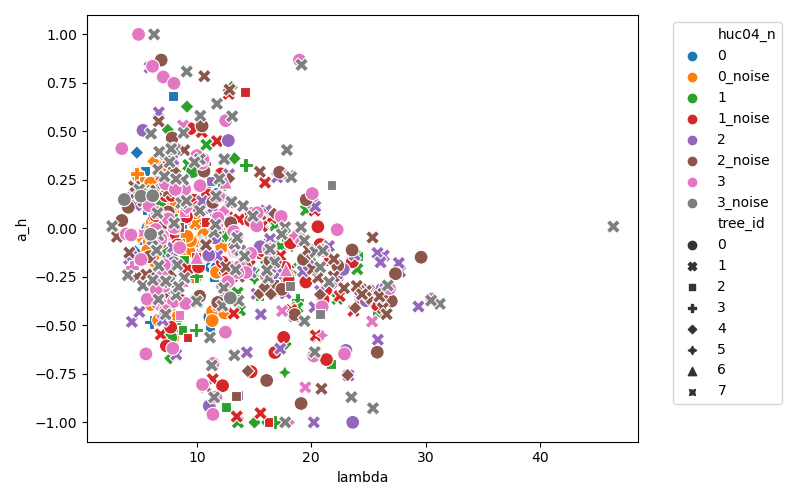

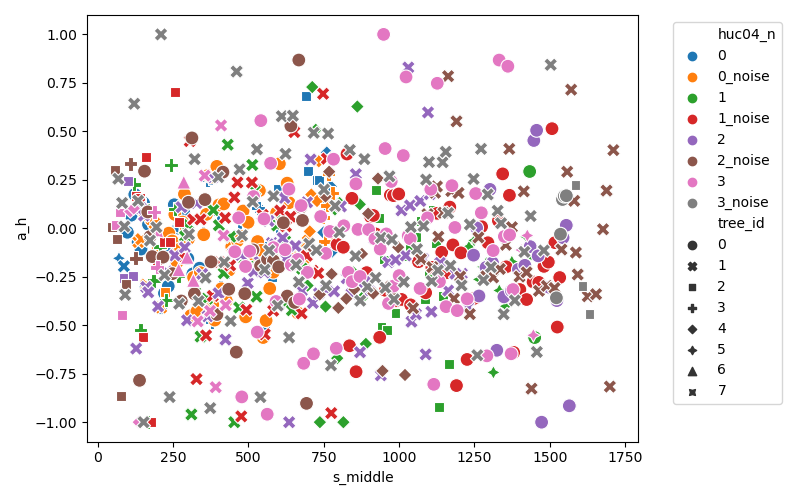

In [36]:
database = rivers.get_metric_databases()
plt.figure(figsize=(8, 5))
sns.scatterplot(data=database, x='lambda', y='a_h', hue='huc04_n',
                style='tree_id', s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'synthetic_rivers/results/cwt/lambda_vs_a_h.png',
            dpi=300)
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(data=database, x='s_middle', y='a_h', hue='huc04_n',
                style='tree_id', s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'synthetic_rivers/results/cwt/s_vs_a_h.png',
            dpi=300)
plt.show()


In [17]:
meander = rivers['0'].meanders[0]
fig = meander.plot_meander()
plt.show()

## References

Howard, A. D., & Knutson, T. R. (1984). Sufficient conditions for river meandering: A simulation approach. Water Resources Research, 20(11), 1659–1667. https://doi.org/10.1029/WR020i011p01659

Sylvester, Z. (2023, September 14). zsylvester/meanderpy. Python. Retrieved from https://github.com/zsylvester/meanderpy (Original work published November 21, 2018)
